# Imports

In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image, ImageTk

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

import cv2
import tempfile
import tkinter as tk
from tkinter import filedialog, messagebox, Tk, Label, Button

# Directories

In [2]:
color_data_dir = "../data/colorData"
number_data_dir = "../data/numberData"
special_card_data_dir = "../data/specialCardData"
preprocessed_data_dir = "../data/preprocessedData"

# Preprocessing

In [3]:
def preprocess_and_save_images(directory, target_size=(300, 300)):
    images = []
    labels = []

    if os.path.isdir(directory):
        for label in os.listdir(directory):
            class_dir = os.path.join(directory, label)
            if os.path.isdir(class_dir):
                for img_name in os.listdir(class_dir):
                    img_path = os.path.join(class_dir, img_name)
                    try:
                        img = Image.open(img_path).convert('RGB')
                        img = img.resize(target_size)
                        img_array = np.array(img, dtype=np.float32) / 255.0

                        images.append(img_array)
                        labels.append(label)
                    except Exception as e:
                        print(f"Error processing image {img_path}: {e}")

    # Encode labels as integers
    unique_labels = np.unique(labels)
    label_dict = {label: index for index, label in enumerate(unique_labels)}
    labels_encoded = np.array([label_dict[label] for label in labels], dtype=np.int64)

    return np.array(images, dtype=np.float32), labels_encoded, unique_labels


Preprocessing Images and Data Labels

In [4]:
color_images, color_labels, unique_color_labels = preprocess_and_save_images(color_data_dir)
number_images, number_labels, unique_number_labels = preprocess_and_save_images(number_data_dir)
special_card_images, special_card_labels, unique_special_labels = preprocess_and_save_images(special_card_data_dir)

Combining Images and Labels

In [5]:
all_images = np.concatenate([color_images, number_images, special_card_images], axis=0)
all_color_labels = np.concatenate([color_labels, np.full(len(number_labels), -1), np.full(len(special_card_labels), -1)])
all_number_labels = np.concatenate([np.full(len(color_labels), -1), number_labels, np.full(len(special_card_labels), -1)])
all_special_labels = np.concatenate([np.full(len(color_labels), -1), np.full(len(number_labels), -1), special_card_labels])

Ensure that all images and labels have the same length

In [6]:
assert len(all_images) == len(all_color_labels) == len(all_number_labels) == len(all_special_labels), "Data lengths do not match!"

# Train / Test Split

In [7]:
X_train, X_test, y_train_color, y_test_color, y_train_number, y_test_number, y_train_special, y_test_special = train_test_split(
    all_images, all_color_labels, all_number_labels, all_special_labels, test_size=0.2, random_state=42
)

# Creating Datasets

In [8]:
def create_dataset(images, color_labels, number_labels, special_labels, batch_size=16):
    dataset = tf.data.Dataset.from_tensor_slices(
        (images, {"color_output": color_labels, "number_output": number_labels, "special_output": special_labels})
    )
    dataset = dataset.shuffle(len(images)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

Creating Training and Validation Datasets

In [9]:
train_dataset = create_dataset(X_train, y_train_color, y_train_number, y_train_special)
test_dataset = create_dataset(X_test, y_test_color, y_test_number, y_test_special)

Custom Loss function to handle -1 labels

In [10]:
def custom_loss(y_true, y_pred):
    mask = tf.not_equal(y_true, -1)
    y_true_masked = tf.boolean_mask(y_true, mask)
    y_pred_masked = tf.boolean_mask(y_pred, mask)
    
    return tf.keras.losses.sparse_categorical_crossentropy(y_true_masked, y_pred_masked)

# Building the Model

In [11]:
input_layer = Input(shape=(300, 300, 3))
x = Conv2D(32, (3, 3), activation='relu')(input_layer)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)

Output Layers

In [12]:
color_output = Dense(len(unique_color_labels), activation='softmax', name='color_output')(x)
number_output = Dense(len(unique_number_labels), activation='softmax', name='number_output')(x)
special_output = Dense(len(unique_special_labels), activation='softmax', name='special_output')(x)

# Defining, Compiling and Training Model

In [13]:
model = Model(inputs=input_layer, outputs=[color_output, number_output, special_output])

Compiling the model with the custom loss function

In [14]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss={'color_output': custom_loss,
                    'number_output': custom_loss,
                    'special_output': custom_loss},
              metrics={'color_output': 'accuracy',
                       'number_output': 'accuracy',
                       'special_output': 'accuracy'})

Training the Model

In [15]:
history = model.fit(train_dataset, epochs=30, validation_data=test_dataset)

Epoch 1/30
153/153 ━━━━━━━━━━━━━━━━━━━━ 42s 261ms/step - color_output_accuracy: 0.2099 - color_output_loss: 1.8830 - loss: nan - number_output_accuracy: 0.0335 - number_output_loss: 2.9964 - special_output_accuracy: 0.0479 - special_output_loss: nan - val_color_output_accuracy: 0.4344 - val_color_output_loss: nan - val_loss: nan - val_number_output_accuracy: 0.0492 - val_number_output_loss: 2.6538 - val_special_output_accuracy: 0.0984 - val_special_output_loss: nan
Epoch 2/30
153/153 ━━━━━━━━━━━━━━━━━━━━ 41s 269ms/step - color_output_accuracy: 0.4206 - color_output_loss: 0.2612 - loss: nan - number_output_accuracy: 0.0522 - number_output_loss: 2.8170 - special_output_accuracy: 0.1001 - special_output_loss: nan - val_color_output_accuracy: 0.4492 - val_color_output_loss: 0.1046 - val_loss: nan - val_number_output_accuracy: 0.0377 - val_number_output_loss: 2.5853 - val_special_output_accuracy: 0.1082 - val_special_output_loss: nan
Epoch 3/30
153/153 ━━━━━━━━━━━━━━━━━━━━ 41s 269ms/step - 

# Model Metrics

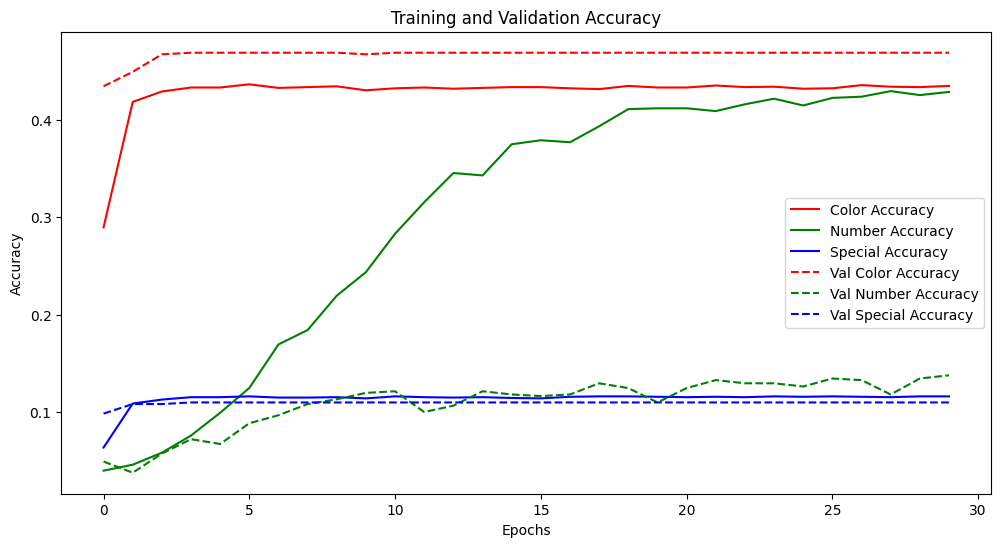

In [16]:
color_accuracy = history.history['color_output_accuracy']
number_accuracy = history.history['number_output_accuracy']
special_accuracy = history.history['special_output_accuracy']
val_color_accuracy = history.history['val_color_output_accuracy']
val_number_accuracy = history.history['val_number_output_accuracy']
val_special_accuracy = history.history['val_special_output_accuracy']

epochs = range(len(color_accuracy))

# Plot training & validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(epochs, color_accuracy, 'r', label='Color Accuracy')
plt.plot(epochs, number_accuracy, 'g', label='Number Accuracy')
plt.plot(epochs, special_accuracy, 'b', label='Special Accuracy')
plt.plot(epochs, val_color_accuracy, 'r--', label='Val Color Accuracy')
plt.plot(epochs, val_number_accuracy, 'g--', label='Val Number Accuracy')
plt.plot(epochs, val_special_accuracy, 'b--', label='Val Special Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Prediction Functions
Predicting with a File Path

In [17]:
def predict_uno_card(image_path):
    img = Image.open(image_path).convert('RGB')
    img = img.resize((300, 300))

    # plt.imshow(img)
    # plt.title("Resized Image")
    # plt.axis('off')
    # plt.show()

    img_array = np.array(img, dtype=np.float32) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Make predictions
    color_prediction, number_prediction, special_prediction = model.predict(img_array)
    color_label = unique_color_labels[np.argmax(color_prediction)]
    number_label = unique_number_labels[np.argmax(number_prediction)]
    special_label = unique_special_labels[np.argmax(special_prediction)]

    # print(f"Predicted color: {color_label}")
    # print(f"Predicted number: {number_label}")
    # print(f"Is special card: {special_label}")

    return f"Predicted color: {color_label}\nPredicted number: {number_label}\nIs special card: {special_label}"

Predicting with an image

In [24]:
def predict_uno_card_with_img(img):
    img = img.resize((300, 300))
    img = img.convert('RGB')

    img_array = np.array(img, dtype=np.float32) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Make predictions
    color_prediction, number_prediction, special_prediction = model.predict(img_array)
    color_label = unique_color_labels[np.argmax(color_prediction)]
    number_label = unique_number_labels[np.argmax(number_prediction)]
    special_label = unique_special_labels[np.argmax(special_prediction)]

    return f"{color_label}{number_label} Special:{special_label}"

# GUI
Function to upload an Image from the computer

In [25]:
def upload_image(main_window):
    try:
        # Open the file dialog to select an image
        file_path = filedialog.askopenfilename(
            title="Select an Image",
            filetypes=[("Image Files", "*.png;*.jpg;*.jpeg;*.gif;*.bmp")]
        )
        
        # If no file is selected (cancel button is clicked)
        if not file_path:
            messagebox.showinfo("No file selected", "You did not select an image.")
            return

        # Try to open the image using Pillow
        try:
            image = Image.open(file_path)

            # Call your existing predict_uno_card function
            prediction = predict_uno_card(file_path)
            
            # Show the result in a separate small window (new tkinter window)
            result_window = tk.Toplevel(main_window)
            result_window.title("Prediction Result")
            result_label = tk.Label(result_window, text=prediction, font=("Arial", 12))
            result_label.pack(padx=20, pady=20)
            result_button = tk.Button(result_window, text="Close", command=result_window.destroy)
            result_button.pack(pady=10)

            result_window.geometry("300x150")  # Set a small window size for the result

        except Exception as e:
            messagebox.showerror("Error", f"An error occurred while opening the image: {e}")
        
    except Exception as e:
        messagebox.showerror("Error", f"An error occurred: {e}")

Function to Start the Livestream for Live Detection

In [26]:
def start_livestream():
    cap = cv2.VideoCapture(0)
    
    # Create a new window for edge detection
    edge_window = cv2.namedWindow("Edge Detection")

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        height, width, _ = frame.shape
        start_x = width // 4
        start_y = height // 4
        end_x = 3 * width // 4
        end_y = 3 * height // 4

        square_frame = frame[start_y:end_y, start_x:end_x]

        # Convert from BGR to RGB
        input_image = cv2.cvtColor(square_frame, cv2.COLOR_BGR2RGB)

        # Convert the frame to a PIL Image object
        input_image = Image.fromarray(input_image)

        prediction = predict_uno_card_with_img(input_image)

        # Draw bounding box and label
        cv2.rectangle(frame, (start_x, start_y), (end_x, end_y), (0, 255, 0), 2)
        cv2.putText(frame, f'{prediction}', (start_x, start_y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

        # Show the original video feed with bounding box
        cv2.imshow('Video Feed', frame)
        
        # Apply edge detection to the marked area and display it in a new window
        gray = cv2.cvtColor(square_frame, cv2.COLOR_BGR2GRAY)
        edges = cv2.Canny(gray, 100, 200)
        cv2.imshow("Edge Detection", edges)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

Starting the GUI using Tkinter, and Binding the Functions to the buttons

In [28]:
# Create the main window
root = tk.Tk()
root.title("Image and Livestream Prediction")
root.geometry("400x200")  # Set window size

# Create buttons with larger size
upload_button = tk.Button(root, text="Upload Image", command=lambda: upload_image(root), width=20, height=2)
upload_button.pack(pady=20)
livestream_button = tk.Button(root, text="Start Livestream", command=start_livestream, width=20, height=2)
livestream_button.pack(pady=20)

# Run the application
root.mainloop()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━